# Descripción del proyecto

Somos analistas en una gran tienda en línea. Junto con el departamento de marketing se ha recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos.
Debemos priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

# Descripción de los datos

La informacion en este analisis está dividido en 3 datasets:

Dataframe de hipótesis:

* `Hypotheses`: breves descripciones de las hipótesis
* `Reach`: alcance del usuario, en una escala del uno a diez
* `Impact`: impacto en los usuarios, en una escala del uno al diez
* `Confidence`: confianza en la hipótesis, en una escala del uno al diez
* `Effort`: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba.

Dataframe de pedidos:

* `transactionId`: identificador de pedido
* `visitorId`: identificador del usuario que realizó el pedido
* `date`: fecha del pedido
* `revenue`: ingresos del pedido
* `group`: el grupo del test A/B al que pertenece el usuario

Dataframe de visitas:
* `date`: la fecha
* `group`: grupo del test A/B
* `visits`: el número de visitas en la fecha especificada para el grupo de test A/B especificado

# Pasos a seguir

* Paso 1. Inicialización: Abrir y estudiar la informacion general
* Paso 2. Preparar los datos
* Paso 3. Priorizar hipótesis
* Paso 4. Análisis de test A/B
* Paso 5. Decisión basada en los resultados.

# Paso 1. Inicialización: Abrir y estudiar la informacion general

Procederemos a importar los archivos y estudiar la información general de estos para saber como pre-procesarlos.

In [32]:
#importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from math import ceil as math
from scipy import stats as st

In [33]:
#Cargamos los archivos de datos
try:
  hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
except:
  hypotheses = pd.read_csv('/content/hypotheses_us.csv', sep=';')

try:
  orders = pd.read_csv('/datasets/orders_us.csv', sep=',')
except:
  orders = pd.read_csv('/content/orders_us.csv', sep=',')

try:  
  visits = pd.read_csv('/datasets/visits_us.csv', sep=',')
except:
  visits = pd.read_csv('/content/visits_us.csv', sep=',')

## Estudiando datos de archivo de hipótesis.

In [34]:
# previsualizar los datos cargados
hypotheses.info()

# devolver las n filas superiores del dataframe
hypotheses.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [35]:
#Visualizar estadisticas descriptivas
hypotheses.describe()

,Reach,Impact,Confidence,Effort
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


In [36]:
# validando valores ausentes y duplicados
display(hypotheses.isna().any().any())
display(hypotheses.duplicated().sum())

False

0

Los datos están bastante limpios, podemos renombrar las columnas para que sigan el estilo de escritura snake case para mantener la homogeneidad.

## Estudiando datos de archivo de pedidos.

In [37]:
# previsualizar los datos cargados
orders.info()

# devolver las n filas superiores del dataframe
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
6,398296753,2900797465,2019-08-15,30.6,B
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
9,1506739906,1882260405,2019-08-15,30.5,B


In [38]:
#Visualizar estadisticas descriptivas
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1197.000000
mean,2.155621e+09,2.165960e+09,131.491646
std,1.229085e+09,1.236014e+09,603.004729
min,1.062393e+06,5.114589e+06,5.000000
25%,1.166776e+09,1.111826e+09,20.800000
50%,2.145194e+09,2.217985e+09,50.200000
75%,3.237740e+09,3.177606e+09,130.400000
max,4.293856e+09,4.283872e+09,19920.400000


In [39]:
# validando valores ausentes y duplicados
display(orders.isna().any().any())
display(orders.duplicated().sum())

False

0

Los datos también están bastante limpios, solo notamos que hay columnas que es necesario convertir a datetime.

## Estudiando datos de archivo de visitas.

In [40]:
# previsualizar los datos cargados
visits.info()

# devolver las n filas superiores del dataframe
visits.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [41]:
#Visualizar estadisticas descriptivas
visits.describe()

,visits
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [42]:
# validando valores ausentes y duplicados
display(visits.isna().any().any())
display(visits.duplicated().sum())

False

0

Los datos también están bastante limpios, solo notamos que hay columnas que es necesario convertir a datetime.

## Conclusión
Los datasets están bastante limpios, no hay discrepancias ni grandes problemas. Solo debemos renombrar y convertir los tipos de datos de algunas columnas.

# Paso 2. Preparar los datos

Ahora que ya conocermos nuestros datos, podemos proceder a corregir los detalles detectados.

In [43]:
#modificamos los nombres de las columnas para nuestras tablas
hypotheses.rename(columns = {'Hypothesis':'hypothesis',
                             'Reach':'reach',
                             'Impact':'impact',
                             'Confidence':'confidence',
                             'Effort':'effort'}, inplace = True)
#cambiando tipo de datos a datetime
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

In [44]:
# Eliminando duplicados
orders = orders.drop_duplicates()
visits = visits.drop_duplicates()

# Eliminando valores ausentes
orders = orders.dropna()
visits = visits.dropna()

In [45]:
# validando si algun visitante entro en ambos grupos
orders[orders.groupby('visitorId')['group'].transform('nunique') > 1]

,transactionId,visitorId,date,revenue,group
2,2961555356,4069496402,2019-08-15,10.2,A
20,2904772834,963407295,2019-08-15,5.6,B
23,4252514150,351125977,2019-08-15,235.6,B
24,1162046357,3234906277,2019-08-15,120.2,B
26,2223239646,199603092,2019-08-15,55.7,A
...,...,...,...,...,...
1182,2682156369,1668030113,2019-08-14,20.8,B
1183,1458356232,963407295,2019-08-14,80.0,A
1184,1329499668,2949041841,2019-08-14,160.7,B
1189,4082620617,393266494,2019-08-14,490.4,B


In [46]:
# eliminando visitantes presentes en ambos grupos
orders.drop(orders
             [orders.groupby('visitorId')['group'].transform('nunique') > 1]
             .index, 
             inplace = True)

orders.group.value_counts()

B    548
A    468
Name: group, dtype: int64

##Conclusion

Corregimos los detalles detectados y adicional notamos que habían 181 visitantes que se encontraban en ambos grupos. Un test A/B debe ser realizado entre 2 grupos independientes por lo que hemos filtrado a estos visitantes que se encontraban en ambos grupos.

# Paso 3. Priorizar hipótesis

##Aplicando el framework ICE para priorizar hipótesis.

Para priorizar las hipótesis comenzaremos aplicando el framework ICE y las ordenaremos en orden descendente segun prioridad.

In [47]:
# Para cada fila aplicamos la formula (impacto * confianza) / esfuerzo

hypotheses['ICE'] = (hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort']

display(hypotheses[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


Las hipótesis más prometedoras son la 8,0 y 7, ya que tienen el mayor valor ICE (sobre 11). La hipótesis 4 es la que tiene la menor prioridad.

##Aplicando el framework RICE para priorizar hipótesis.

In [48]:
# Para cada fila aplicamos la formula (impacto * confianza * alcance) / esfuerzo

hypotheses['RICE'] = (hypotheses['reach']*hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort']

# sort in descending order
display(hypotheses[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


Las hipótesis más prometedoras con el framework RICE son la 7, 2, 0 y 6, mientras que la 4 sigue siendo la que tiene la menor prioridad. La priorización de hipótesis cambio al usar RICE en lugar de ICE.

## Contraste entre aplicar RICE en lugar de ICE.

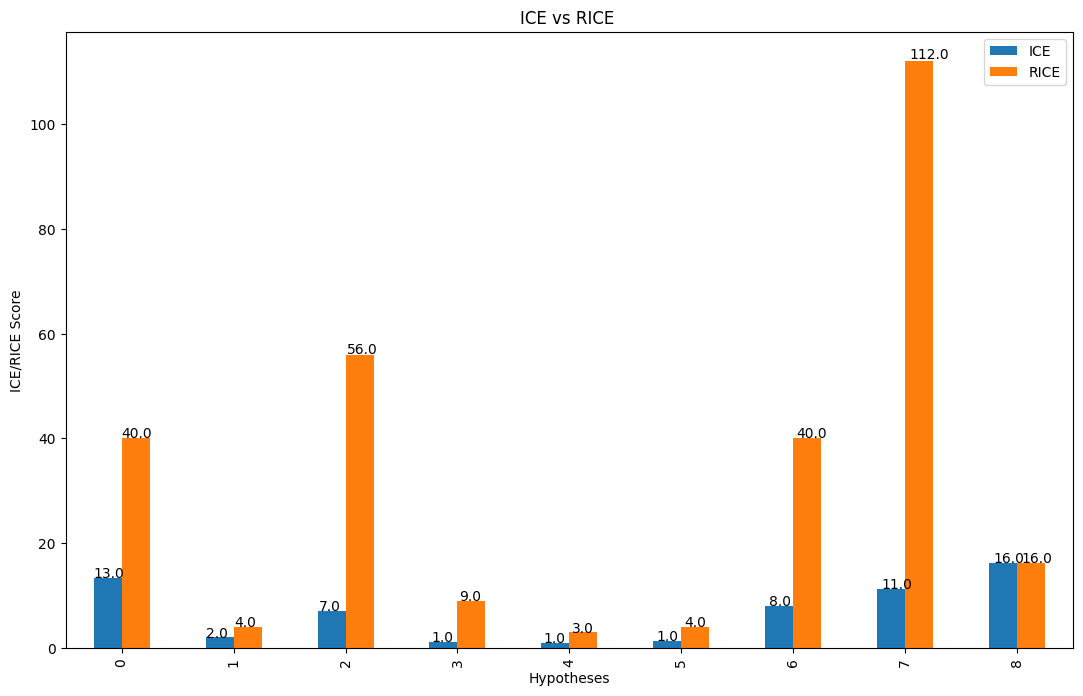

In [49]:
# Graficamos para mostrar el contraste entre utilizar ICE y RICE

ax = hypotheses[['hypothesis','ICE','RICE']].plot(kind='bar',stacked=False, figsize=(13,8))

for p in ax.patches:
    ax.annotate(str(p.get_height().round()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
plt.title('ICE vs RICE ')
plt.xlabel('Hypotheses')
plt.ylabel('ICE/RICE Score')
plt.show()

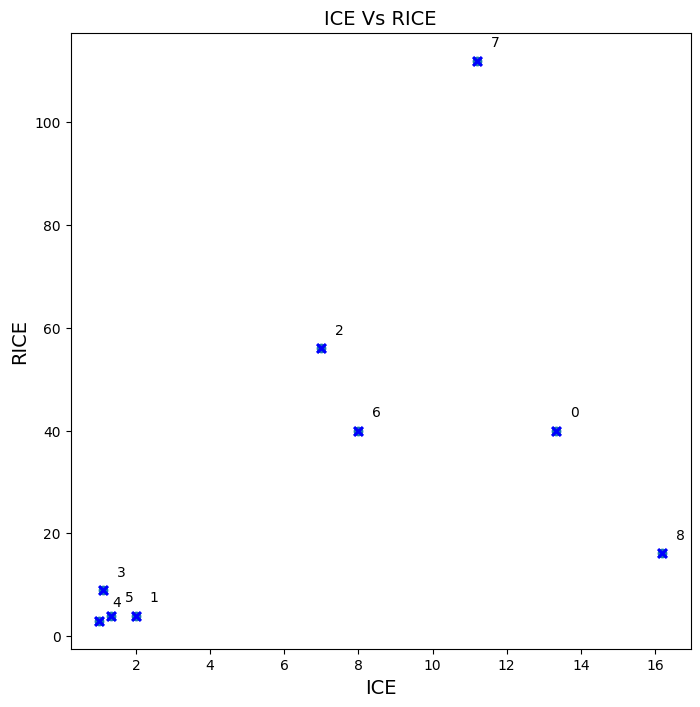

In [50]:
# Grafico de dispersión para visualizar la hipótesis con más prioridad

x = hypotheses['ICE'].values
y = hypotheses['RICE'].values
types = hypotheses.index.values

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y)

ax.set_xlabel('ICE', fontsize=14)
ax.set_ylabel('RICE', fontsize=14)
ax.set_title('ICE Vs RICE', fontsize=14)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='blue')

El Framework ICE  toma en cuenta `(impacto * confianza) / esfuerzo` :

*  Cuánto impacto tiene un cambio en los usuarios alcanzados.
*  Qué tan seguro/a estás de tus estimaciones para los otros parámetros.
*  Qué tan difícil es probar una hipótesis.

El framework RICE adicionalmente considera `ICE * Alcance` :
* Cuantos usuarios serán afectados por el cambio.

Una vez el alcance fue tomado en consideración la hipótesis 7 toma la delantera al tener el mayor alcance, esta hipótesis también tuvo una posición relevante con el framework ICE por lo que es una clara ganadora. Por otro lado la hipótesis número 8 que para el framework ICE era la más priorizada no aumento nada ya que tiene un alcance de 1 mientras que la 7 un alcance de 10.

Del grafico de dispersión podemos notar más claramente como la hipótesis 7 es la más alta para ambos casos.





# Paso 4. Análisis de test A/B

Procederemos con el analisis del test A/B

## Representar gráficamente el ingreso acumulado por grupo.

In [51]:
# construimos una matriz con valores únicos de fechas-grupos
revenueGroup = orders[['date','group']].copy()

revenueGroup = revenueGroup.drop_duplicates()

#obteniendo los datos diarios acumulados para ordenes
ordersAggregated = revenueGroup.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
    {'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis= 1 ).sort_values(by=['date','group'])

#obteniendo los datos diarios acumulados para visitantes
visitorsAggregated = revenueGroup.apply(
    lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

#uniendo ambas tablas
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   2266.6       719
1 2019-08-01     B      17      17    967.2       713
2 2019-08-02     A      42      36   3734.9      1338
3 2019-08-02     B      40      39   3535.3      1294
4 2019-08-03     A      66      60   5550.1      1845


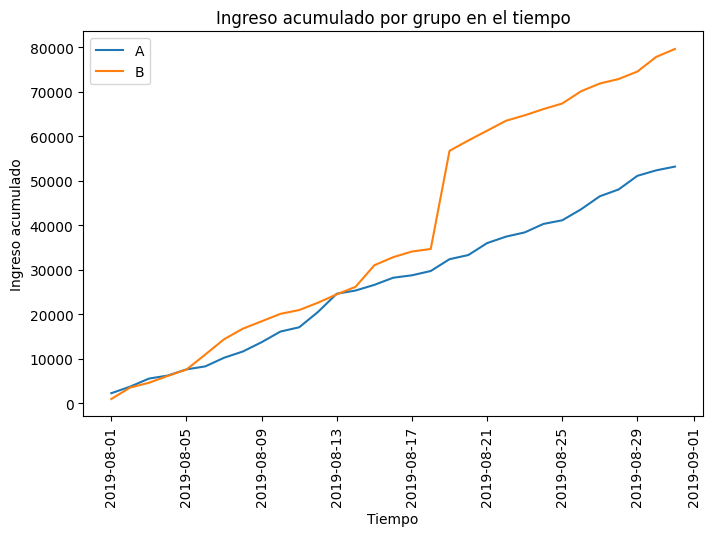

In [52]:
#Separando data acumulada por grupos
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue','orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue','orders']]

plt.figure(figsize=(8,5))
#graficando el ingreso acumulado del grupo A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

#graficando el ingreso acumulado del grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.title('Ingreso acumulado por grupo en el tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Ingreso acumulado')
plt.xticks(rotation=90)
plt.show()

Los ingresos acumulados de ambos grupos aumentaron constantemente durante el transcurso de la prueba, como se ve en el gráfico anterior. Sin embargo, los ingresos del grupo B en 2019 tuvo un pico de ingresos en agosto 17 y luego retomo el ritmo normal (puede implicar un aumento en el número de pedidos o pedidos de alto valor). 

Los ingresos totales del grupo B crecieron y siguieron aumentando al igual que los del A, pero este último a un ritmo menor que el del B.

## Representar gráficamente el tamaño de pedido promedio acumulado por grupo.

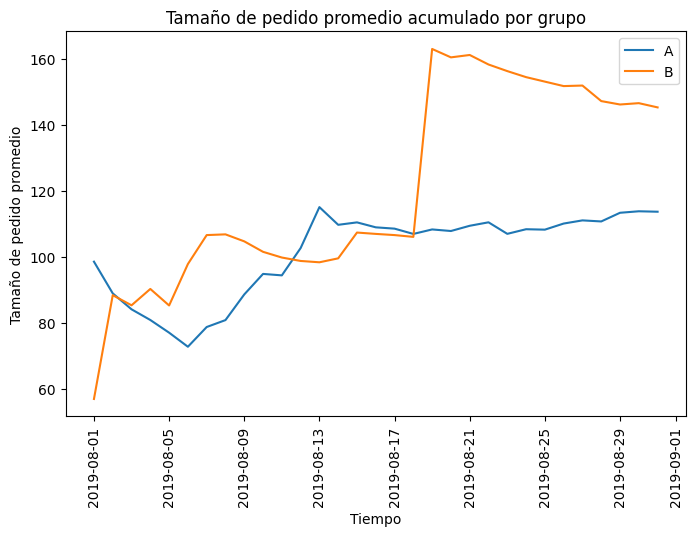

In [53]:
# dividimos los ingresos por los pedidos acumulados
plt.figure(figsize=(8,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend()
plt.title('Tamaño de pedido promedio acumulado por grupo')
plt.xlabel('Tiempo')
plt.ylabel('Tamaño de pedido promedio')
plt.xticks(rotation=90)
plt.show()

Según el gráfico anterior, el tamaño de pedido promedio de ambos grupos es fluctuante. 

El grupo B es bastante inestable, el tamaño promedio de pedidos tiene grandes aumentos el 08-01 y 08-17 y comienza a caer al final.

El grupo A también es inestable pero menos drasticamente. comienza y termina la prueba con valores similares entre 80-120.

## Representacion gráfica de la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.

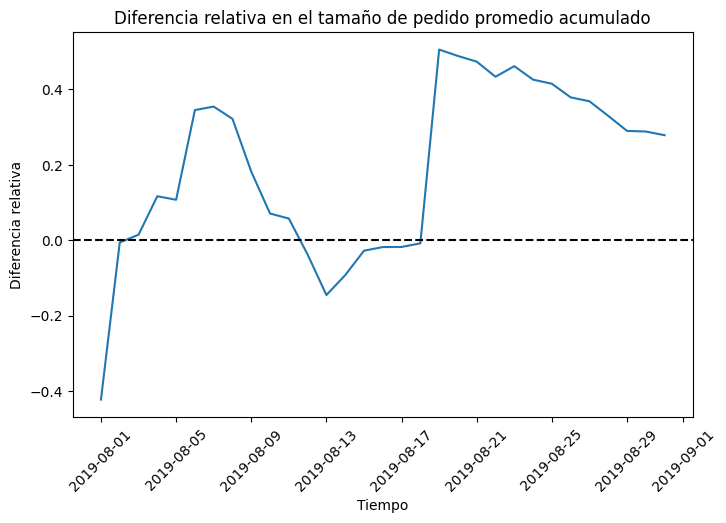

In [54]:
#diferencia relativa en el tamaño de pedido promedio acumulado

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig, ax = plt.subplots()
fig.set_size_inches(8,5)
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

ax.set_title("Diferencia relativa en el tamaño de pedido promedio acumulado")
plt.xlabel("Tiempo")
plt.ylabel("Diferencia relativa")
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

Es razonable suponer que hay valores atípicos basados en este gráfico y los dos anteriores. Como puede verse, el grupo A estaba a la cabeza con un tamaño de pedido promedio acumulado hasta el 1 de agosto, mientras que el grupo B comenzó a tomar la delantera hasta alrededor del 08-09 con un enorme pico (40%~). El Grupo A recuperó el liderato del 08-12 al 08-18, sin embargo la diferencia fue menos dramática (10%). El Grupo B mantuvo su ventaja desde el 18 hasta el final, con diferencias superiores al 40%.

## Calculo de la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representacion gráfica de las tasas de conversión diarias de los dos grupos y describe la diferencia.

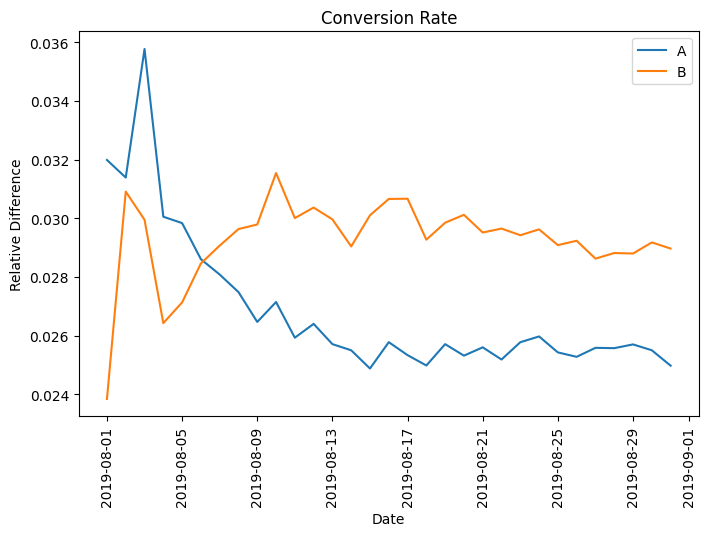

In [55]:
#calculando la conversion
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

#separando la data del grupo A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
#separando la data del grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#Graficando
plt.figure(figsize=(8,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.legend()
plt.title('Conversion Rate')
plt.xlabel('Date')
plt.ylabel('Relative Difference')
plt.xticks(rotation=90)
plt.show()

Basados en el gráfico anterior, la tasa de conversión de ambos grupos fue muy fluctuante. El Grupo B comenzó con un pico mucho más alto al inicio. Después de unos días, el grupo A cayó y el grupo B lideró hasta el final de la prueba.

##Gráfico de dispersión del número de pedidos por usuario.

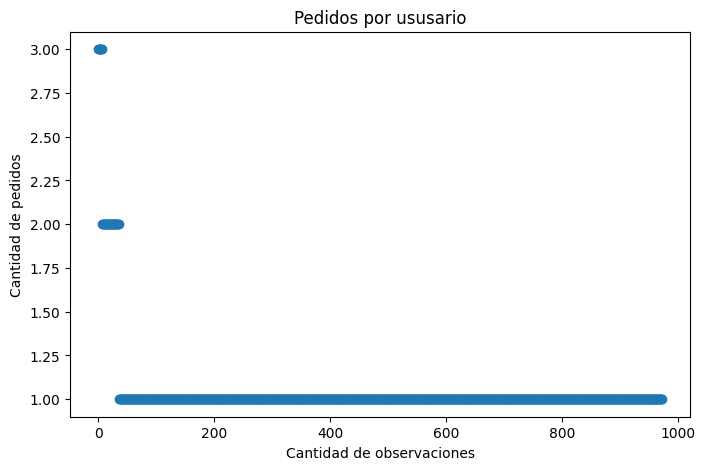

In [56]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})
ordersByUsers.columns = ['userId', 'no_of_orders']

#eliminando duplicados
ordersByUsers = ordersByUsers.drop_duplicates()
#ordenar datos por cantidad de pedidos en orden descendente
ordersByUsers = ordersByUsers.sort_values(by='no_of_orders', ascending=False)
#graficar
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['no_of_orders']) 
ax.set_title("Pedidos por ususario")
plt.xlabel("Cantidad de observaciones")
plt.ylabel("Cantidad de pedidos")
plt.show()

La mayoría de los usuarios realizó una o dos compras, muy pocos usuarios superaron esa cantidad y compraron sobre tres o cuatro.

## Calculo de los percentiles 95 y 99 para el número de pedidos por usuario.

In [57]:
print(np.percentile(ordersByUsers['no_of_orders'], [95,99]))

[1. 2.]


Según el calculo de percentiles, el 95% de las observaciones están dentro de 1 orden por usuario y el 99% dentro de las 2. Por lo tanto, cuando el número de pedidos es superior a 2 pedidos sería el punto en que el valor de los datos se convierte en una anomalía.

## Gráfico de dispersión de los precios de los pedidos. 

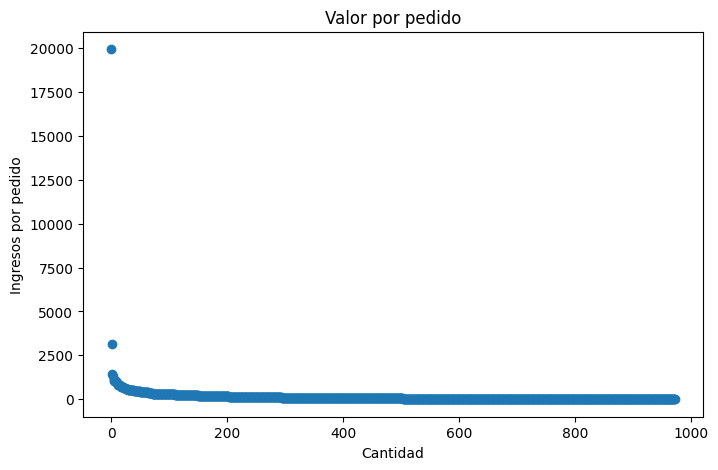

In [58]:
#agrupamos los pedidos por usuario

ordersByPrices= orders.groupby('visitorId', as_index=False).agg({'revenue':'sum'})
ordersByPrices.columns = ['userId', 'revenue']

ordersByPrices = ordersByPrices.drop_duplicates()

# ordenar por cantidad de pedidos
ordersByPrices = ordersByPrices.sort_values(by='revenue', ascending=False)

#buscamos el valor para el axis horizontal con la cantidad de observaciones generadas 
x_values = pd.Series(range(0, len(ordersByPrices)))
plt.figure(figsize=(8,5))
plt.scatter(x_values, ordersByPrices['revenue'])

plt.title('Valor por pedido')
plt.xlabel('Cantidad')
plt.ylabel('Ingresos por pedido')
plt.show()

Según el grafico, los ingresos en su mayoria fueron bajo 2500, hay muy pocos pedidos sobre 2500.

## Calculo de los percentiles 95 y 99 de los precios de los pedidos.

In [59]:
print(np.percentile(ordersByPrices['revenue'], [95,99]))

[449.5   912.576]


No más del 5% de los pedidos cuestan más de 449.5 y no más del 1% cuestan más de $912.576. Podemos definir el punto en el que el valor de los datos se convierte en una anomalía como cualquier observación en la que los ingresos superen los 450.

## Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.

In [60]:
#calculamos la significancia estadística de la diferencia en la conversión entre los grupos
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


AFiltered = pd.concat([ordersByUsersA['orders'], pd.Series(0, index = np.arange(visits[visits['group'] == 'A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)
BFiltered = pd.concat([ordersByUsersB['orders'], pd.Series(0, index = np.arange(visits[visits['group'] == 'B']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

p_value = st.mannwhitneyu(AFiltered, BFiltered)[1]
print('p_value: {0:.3f}'.format(p_value))
print("Tasa de conversion: {0:.3f}".format(BFiltered.mean()/AFiltered.mean()-1))

#nivel de significación
alpha = 0.05

if p_value < alpha:
    print("Hipótesis nula rechazada: la diferencia es estadísticamente significativa")
else:
    print("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia") 

p_value: 0.013
Tasa de conversion: 0.155
Hipótesis nula rechazada: la diferencia es estadísticamente significativa


Probamos si existe significancia estadística de la diferencia en la conversión entre los grupos A y B o no mediante el uso de la prueba no paramétrica de Wilcoxon-Mann-Whitney. Esta prueba clasifica dos muestras en orden ascendente y compara las clasificaciones de los valores que aparecen en ambas muestras.

Hipótesis Nula H0: No hay diferencia estadísticamente significativa en la conversión entre los grupos A y B.

Hipótesis alternativa H1: Hay una diferencia estadísticamente significativa en la conversión entre los grupos A y B.

El valor p es menor que el nivel alfa, lo que significa que podemos rechazar la hipótesis nula y determinar que la diferencia entre la tasa de conversión de los grupos A y B es estadísticamente significativa.

Por lo tanto, la ganancia relativa del grupo B de aproximadamente 16% es significativa.

## Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. 

In [61]:
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print('p_value: {0:.3f}'.format(p_value))

#nivel de significación
alpha = 0.05

if p_value < alpha:
    print("Hipótesis nula rechazada: la diferencia es estadísticamente significativa")
else:
    print("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia") 

p_value: 0.862
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


Probamos la significación estadística de la diferencia en el tamaño promedio de pedido entre los grupos A y B mediante el uso de la prueba no paramétrica de Wilcoxon-Mann-Whitney. Esta prueba clasifica dos muestras en orden ascendente y compara las clasificaciones de los valores que aparecen en ambas muestras.

Hipótesis nula H0: No existe una diferencia estadísticamente significativa en el tamaño promedio de los pedidos entre los grupos A y B.

Hipótesis alternativa H1: existe una diferencia estadísticamente significativa en el tamaño promedio de los pedidos entre los grupos A y B.

El valor p es mayor que el nivel alfa, lo que significa que rechazamos la hipótesis nula y determinamos que la diferencia en el tamaño promedio de pedido de los grupos A y B no es estadísticamente significativa. Sin embargo, hay una ganancia relativa para el grupo B (alrededor del 28%).

##Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados

In [63]:
#identificamos los usuarios anomalos con demasiados pedidos
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['userId']], axis = 0)

# identificamos los usuarios anomalos con pedidos muy caros
usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['visitorId']

# los unimos en una tabla conjunta
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

# calculamos la significandia estadistica de la diferencia de conversion entre grupos usando el dataframe filtrado
AFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

BFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

print('p_value: {0:.3f}'.format(stats.mannwhitneyu(AFiltered, BFiltered)[1]))
print("Tasa de conversion:{0:.3f}".format(BFiltered.mean()/AFiltered.mean()-1)) 

#nivel de significación
alpha = 0.05

if p_value < alpha:
    print("Hipótesis nula rechazada: la diferencia es estadísticamente significativa")
else:
    print("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia") 

p_value: 0.011
Tasa de conversion:0.160
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


Filtramos los datos sin procesar de dos maneras: número de pedidos e importe por pedido. 

Hipótesis H0:
No hay diferencia estadísticamente significativa en el cambio entre los grupos A y B.

Hipótesis alternativa H1:
Hay una diferencia estadísticamente significativa en el cambio entre los grupos A y B.

El valor P es menor que el valor alfa, lo que significa que podemos rechazar la hipótesis nula y ver que la diferencia entre la tasa de conversion de los grupos A y B no es estadísticamente significativa. Por lo tanto, la ganancia relativa del grupo B de aproximadamente 17% es significativa

##Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.

In [64]:
p_value = st.mannwhitneyu(orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]

print('p_value: {0:.3f}'.format(p_value))

#nivel de significación
alpha = 0.05

if p_value < alpha:
    print("Hipótesis nula rechazada: la diferencia es estadísticamente significativa")
else:
    print("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia") 

p_value: 0.862
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


Partimos de la hipótesis nula (H0). Esto significa que no existe una diferencia estadísticamente significativa en el tamaño promedio de los pedidos entre los grupos A y B.

La hipótesis alternativa (H1) establece que existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B.

Usamos un valor alfa de 0,05. Esto significa que solo hay un 5% de posibilidades de rechazar la hipótesis nula si es verdadera.

El valor p es mayor que el valor alfa, por lo que no podemos rechazar la hipótesis nula y concluir que no existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos A y B.

#Paso 5. Decisión basada en los resultados.

* Al principio, consideré que era mejor continuar con la prueba y darle algo de tiempo, tal vez los resultados se estabilicen y tener un mejor conocimiento sobre los costos para poder ver el panorama completo.
* Después de pasar por la prueba de hipótesis, se ha establecido que los grupos son diferentes por tasa de conversión.
* Con base a estos resultados, podemos tomar la decisión de detener la prueba, considerar al grupo B como el líder
* Es seguro hacer una recomendación basada en datos a los especialistas en marketing de que el grupo B es mejor ya que genera mayores ingresos acumulativos y tiene mayores tamaños de pedido promedio.
* Aunque no hay una diferencia significativa entre los grupos teniendo en cuenta el tamaño medio de sus pedidos, existe una diferencia estadísticamente significativa en la conversión entre los grupos y la ganancia de conversión relativa del grupo B es significativa. Por lo tanto, la prueba es exitosa.